# Trabalho Final — Deteccao de Placas Circulares

Este notebook implementa um pipeline completo de **deteccao de placas de transito circulares** em imagens reais, utilizando exclusivamente tecnicas classicas de Processamento de Imagens.

## Estrutura do notebook

1. **Imports e configuracoes** — bibliotecas e caminhos de arquivos.
2. **Funcoes do pipeline** — organizadas por etapa:
   - Carregamento e listagem de imagens
   - Conversao de espaco de cor (RGB → HSV) e segmentacao por cor vermelha
   - Pre-processamento morfologico da mascara binaria
   - Deteccao de circulos via Transformada Circular de Hough (CHT)
   - Componentes conectados e metricas geometricas de validacao
   - Funcoes de visualizacao e debug
   - Orquestrador do pipeline completo
3. **Execucao e resultados** — processamento das imagens com debug visual.

## Regras atendidas
- Sem OpenCV e sem PIL.
- Sem aprendizado de maquina.
- Uso apenas de `numpy`, `matplotlib`, `scikit-image` e biblioteca padrao do Python.

## (Opcional) Colab - instalacao de dependencias

No Google Colab, em geral as bibliotecas principais ja existem.
Se precisar, descomente e rode a celula abaixo.


In [ ]:
# %pip install -q numpy matplotlib scikit-image notebook ipykernel


## 0) Imports e configuracoes gerais

A celula abaixo importa todas as bibliotecas utilizadas no projeto:

- **`csv` / `json`** — leitura e escrita de arquivos de dados (biblioteca padrao do Python).
- **`pathlib.Path`** — manipulacao de caminhos de arquivo de forma multiplataforma.
- **`time.perf_counter`** — cronometro de alta resolucao para medir o tempo de execucao do pipeline.
- **`numpy`** — operacoes numericas e manipulacao de arrays (base de toda computacao com imagens).
- **`matplotlib.pyplot`** — exibicao e salvamento de graficos e imagens.
- **`skimage.io.imread`** — leitura de imagens do disco em formato NumPy array.
- **`skimage.img_as_float`** — conversao dos valores de pixel para o intervalo `[0.0, 1.0]`.
- **`skimage.color.rgb2hsv`** — conversao do espaco de cor RGB para HSV.
- **`skimage.morphology`** — operacoes morfologicas (abertura, fechamento, erosao) e elementos estruturantes.
- **`skimage.measure`** — rotulagem de componentes conectados, propriedades de regioes e calculo de perimetro.
- **`skimage.transform`** — Transformada Circular de Hough (CHT) e deteccao de picos no espaco acumulador.
- **`skimage.draw`** — desenho de primitivas geometricas (perimetro de circulo) sobre imagens.

In [ ]:
# ---------- Biblioteca padrao do Python ----------
import csv                          # Escrita de arquivos CSV
import json                         # Leitura de anotacoes opcionais em JSON
from pathlib import Path            # Manipulacao de caminhos de forma multiplataforma
from time import perf_counter       # Cronometro de alta resolucao

# ---------- Computacao numerica ----------
import numpy as np                  # Arrays n-dimensionais e operacoes vetorizadas

# ---------- Visualizacao ----------
import matplotlib.pyplot as plt     # Exibicao de imagens e graficos

# ---------- Scikit-image: leitura e conversao ----------
from skimage.io import imread                       # Leitura de imagens do disco
from skimage import img_as_float                    # Conversao para float [0, 1]
from skimage.color import rgb2hsv                   # Conversao RGB -> HSV

# ---------- Scikit-image: morfologia matematica ----------
from skimage.morphology import (
    opening,                                        # Abertura (erosao + dilatacao)
    closing,                                        # Fechamento (dilatacao + erosao)
    erosion,                                        # Erosao morfologica
    disk,                                           # Elemento estruturante circular
    remove_small_holes,                             # Preenche buracos em mascaras
)

# ---------- Scikit-image: analise de regioes ----------
from skimage.measure import (
    label,                                          # Rotulagem de componentes conectados
    regionprops,                                    # Propriedades geometricas de cada regiao
    perimeter as measure_perimeter,                 # Calculo do perimetro de uma regiao
)

# ---------- Scikit-image: Transformada de Hough ----------
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

# ---------- Configuracoes globais do matplotlib ----------
plt.rcParams["figure.figsize"] = (14, 4)   # Tamanho padrao das figuras
plt.rcParams["axes.grid"] = False           # Desabilitar grade nos graficos

### Definicao dos diretorios de trabalho

A celula seguinte define os **tres diretorios principais** do projeto:

| Variavel | Caminho | Descricao |
|---|---|---|
| `DATA_ROOT` | `data/` | Pasta onde as imagens de entrada devem estar. |
| `RESULTS_ROOT` | `results/` | Pasta raiz para todos os resultados gerados. |
| `DEBUG_DIR` | `results/debug_images/` | Subpasta para as imagens de debug salvas automaticamente. |

Os diretorios sao criados automaticamente caso ainda nao existam (via `mkdir`).

In [ ]:
# Diretorio onde as imagens de entrada estao armazenadas
DATA_ROOT = Path("data")

# Diretorio raiz para todos os resultados do pipeline
RESULTS_ROOT = Path("results")

# Subdiretorio para imagens de debug (overlay com circulos detectados)
DEBUG_DIR = RESULTS_ROOT / "debug_images"

# Criar os diretorios caso nao existam
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)
DEBUG_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT:", DATA_ROOT.resolve())
print("RESULTS_ROOT:", RESULTS_ROOT.resolve())
print("DEBUG_DIR:", DEBUG_DIR.resolve())

DATA_ROOT: /home/givaldo/pi-trabalho-final-placas-circulares/data
RESULTS_ROOT: /home/givaldo/pi-trabalho-final-placas-circulares/results
DEBUG_DIR: /home/givaldo/pi-trabalho-final-placas-circulares/results/debug_images


## 1) Funcoes do pipeline

As funcoes abaixo estao organizadas por etapa do pipeline de deteccao.

### 1.1) Carregamento e listagem de imagens

A celula seguinte define:

- **`EXTENSOES_IMAGEM_VALIDAS`** — conjunto com as extensoes de arquivo aceitas como imagens.
- **`listar_imagens()`** — varre recursivamente o diretorio de dados e retorna uma lista ordenada de caminhos para todas as imagens encontradas.
- **`carregar_imagem()`** — le um arquivo de imagem do disco e o converte para um array NumPy float64 com 3 canais (RGB), com valores normalizados entre 0.0 e 1.0. Trata automaticamente imagens em escala de cinza (replica para 3 canais) e RGBA (descarta o canal alfa).

In [ ]:
# ---------------------------------------------------------------------------
# Extensoes de arquivo aceitas como imagens validas
# ---------------------------------------------------------------------------
EXTENSOES_IMAGEM_VALIDAS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}


def listar_imagens(diretorio_raiz=DATA_ROOT):
    """
    Varre recursivamente o diretorio informado e retorna uma lista ordenada
    de caminhos (Path) para todos os arquivos de imagem encontrados.

    Parametros
    ----------
    diretorio_raiz : Path ou str
        Caminho do diretorio onde buscar imagens. Padrao: DATA_ROOT.

    Retorno
    -------
    list[Path]
        Lista ordenada de caminhos das imagens encontradas.
        Retorna lista vazia se o diretorio nao existir ou nao conter imagens.
    """
    diretorio = Path(diretorio_raiz)

    if not diretorio.exists():
        print(f"Pasta '{diretorio}' nao encontrada. Coloque imagens em data/.")
        return []

    caminhos_imagens = sorted(
        caminho
        for caminho in diretorio.rglob("*")
        if caminho.is_file() and caminho.suffix.lower() in EXTENSOES_IMAGEM_VALIDAS
    )

    if not caminhos_imagens:
        print(f"Nenhuma imagem valida encontrada em {diretorio}.")

    return caminhos_imagens


def carregar_imagem(caminho_arquivo):
    """
    Le uma imagem do disco e a converte para um array NumPy float64 no
    intervalo [0.0, 1.0] com exatamente 3 canais (RGB).

    Tratamentos realizados:
    - Imagens em escala de cinza (2D) sao replicadas em 3 canais.
    - Imagens RGBA (4 canais) tem o canal alfa removido.
    - Valores de pixel sao normalizados de [0, 255] para [0.0, 1.0].

    Parametros
    ----------
    caminho_arquivo : Path ou str
        Caminho completo do arquivo de imagem.

    Retorno
    -------
    np.ndarray
        Array float64 de shape (altura, largura, 3) com valores em [0, 1].
    """
    imagem_bruta = imread(caminho_arquivo)

    # Imagem em escala de cinza (2D): replicar em 3 canais para simular RGB
    if imagem_bruta.ndim == 2:
        imagem_bruta = np.stack(
            [imagem_bruta, imagem_bruta, imagem_bruta], axis=-1
        )
    # Imagem RGBA (4 canais): descartar o canal alfa (transparencia)
    elif imagem_bruta.ndim == 3 and imagem_bruta.shape[2] == 4:
        imagem_bruta = imagem_bruta[..., :3]

    return img_as_float(imagem_bruta)

### 1.2) Conversao HSV, segmentacao por cor vermelha e pre-processamento morfologico

A celula seguinte define tres funcoes que compõem as primeiras etapas de processamento:

**`converter_para_hsv()`** — Converte a imagem do espaco de cor RGB para **HSV** (Hue, Saturation, Value). No HSV a informacao de **cor** (canal H) fica separada da **iluminacao** (canal V), o que torna a segmentacao por cor muito mais robusta do que no RGB.

**`segmentar_vermelho_hsv()`** — Gera uma mascara binaria dos pixels vermelhos. O vermelho no HSV e especial porque ocupa **duas faixas** do canal Hue (matiz e circular: 0° = 360°):
- Faixa 1: Hue entre ~0° e ~25° (vermelho puro, proximo de 0)
- Faixa 2: Hue entre ~335° e ~360° (vermelho puro, proximo de 1)

Alem do Hue, exigimos **saturacao minima** (evitar cinzas) e **valor minimo** (evitar pixels muito escuros).

**`preprocessar_mascara()`** — Limpa a mascara binaria com **duas operacoes morfologicas**:
1. **Abertura** (opening = erosao + dilatacao): remove ruidos pequenos e pontos isolados.
2. **Fechamento** (closing = dilatacao + erosao): preenche lacunas e conecta regioes proximas.

O **elemento estruturante** usado e um **disco** (circular), adequado para formas arredondadas.

In [ ]:
def converter_para_hsv(imagem_rgb):
    """
    Converte uma imagem do espaco de cor RGB para o espaco HSV.

    No espaco HSV:
    - H (Hue / Matiz): indica a cor dominante, valor em [0, 1] mapeando [0, 360].
    - S (Saturation / Saturacao): intensidade da cor, 0 = cinza, 1 = cor pura.
    - V (Value / Valor): brilho do pixel, 0 = preto, 1 = brilho maximo.

    A segmentacao por cor no espaco HSV e mais robusta que no RGB porque
    separa a informacao de cor (H) da iluminacao (V).

    Parametros
    ----------
    imagem_rgb : np.ndarray
        Imagem RGB float64 com shape (altura, largura, 3).

    Retorno
    -------
    np.ndarray
        Imagem HSV float64 com shape (altura, largura, 3).
    """
    return rgb2hsv(imagem_rgb)


def segmentar_vermelho_hsv(
    imagem_hsv,
    hue_minimo_faixa1=0.00,
    hue_maximo_faixa1=0.07,
    hue_minimo_faixa2=0.93,
    hue_maximo_faixa2=1.00,
    saturacao_minima=0.35,
    valor_minimo=0.20,
):
    """
    Gera uma mascara binaria dos pixels vermelhos de uma imagem HSV.

    O vermelho no espaco HSV ocupa DUAS faixas de Hue (matiz circular):
      - Faixa 1: hue proximo de 0  (vermelho puro, ~0 a ~25 graus)
      - Faixa 2: hue proximo de 1  (vermelho puro, ~335 a 360 graus)

    Alem do Hue, exigimos saturacao e valor minimos para evitar
    selecionar pixels acinzentados ou muito escuros.

    Parametros
    ----------
    imagem_hsv : np.ndarray
        Imagem no espaco HSV com shape (altura, largura, 3), valores em [0, 1].
    hue_minimo_faixa1 : float
        Limite inferior da primeira faixa de Hue (padrao 0.00).
    hue_maximo_faixa1 : float
        Limite superior da primeira faixa de Hue (padrao 0.07).
    hue_minimo_faixa2 : float
        Limite inferior da segunda faixa de Hue (padrao 0.93).
    hue_maximo_faixa2 : float
        Limite superior da segunda faixa de Hue (padrao 1.00).
    saturacao_minima : float
        Saturacao minima para considerar o pixel como colorido (padrao 0.35).
    valor_minimo : float
        Valor (brilho) minimo para excluir pixels muito escuros (padrao 0.20).

    Retorno
    -------
    np.ndarray (bool)
        Mascara binaria onde True = pixel vermelho detectado.
    """
    canal_hue = imagem_hsv[..., 0]
    canal_saturacao = imagem_hsv[..., 1]
    canal_valor = imagem_hsv[..., 2]

    # O vermelho "envolve" o circulo de matiz (0 = 360), entao usa duas faixas
    mascara_hue_vermelho = (
        ((canal_hue >= hue_minimo_faixa1) & (canal_hue <= hue_maximo_faixa1))
        | ((canal_hue >= hue_minimo_faixa2) & (canal_hue <= hue_maximo_faixa2))
    )

    # Combinar matiz + saturacao + valor para mascara final
    mascara_vermelha = (
        mascara_hue_vermelho
        & (canal_saturacao >= saturacao_minima)
        & (canal_valor >= valor_minimo)
    )

    return mascara_vermelha


def preprocessar_mascara(mascara_binaria, raio_abertura=1, raio_fechamento=5):
    """
    Aplica operacoes morfologicas para limpar a mascara de segmentacao.

    Etapa 1 - Abertura (opening = erosao + dilatacao):
      Remove pequenos ruidos e pontos isolados (falsos positivos).
      Elemento estruturante: disco com raio `raio_abertura`.

    Etapa 2 - Fechamento (closing = dilatacao + erosao):
      Preenche pequenas lacunas e conecta regioes proximas.
      Elemento estruturante: disco com raio `raio_fechamento`.

    Parametros
    ----------
    mascara_binaria : np.ndarray (bool)
        Mascara de segmentacao bruta (saida de segmentar_vermelho_hsv).
    raio_abertura : int
        Raio do disco para a operacao de abertura (padrao 1).
    raio_fechamento : int
        Raio do disco para a operacao de fechamento (padrao 5).

    Retorno
    -------
    np.ndarray (bool)
        Mascara limpa apos as operacoes morfologicas.
    """
    mascara_aberta = opening(mascara_binaria, disk(raio_abertura))
    mascara_fechada = closing(mascara_aberta, disk(raio_fechamento))
    return mascara_fechada

### 1.3) Transformada Circular de Hough (CHT) e componentes conectados

A celula seguinte implementa as duas funcoes centrais do pipeline:

**`detectar_circulos_hough()`** — Aplica a **Transformada Circular de Hough (CHT)** para encontrar circulos em uma mascara binaria. O funcionamento da CHT:
1. Para cada pixel de **borda** (contorno do componente), vota em todos os possiveis centros de circulo para cada raio candidato.
2. O **espaco acumulador 3D** (centro_x, centro_y, raio) acumula esses votos.
3. Os **picos** no acumulador indicam os circulos com maior evidencia.

Antes da CHT, extraimos as bordas do componente pela **diferenca entre a mascara original e sua erosao** (`mascara XOR erosao`), produzindo apenas os pixels de contorno.

**`separar_componentes_conectados()`** — Identifica regioes isoladas (componentes conectados) na mascara binaria usando **rotulagem por conectividade-8**. Cada componente recebe um identificador unico, e seus atributos (area, bounding box, mascara recortada) sao extraidos via `regionprops`. Componentes com area menor que o limiar minimo sao descartados como ruido.

In [ ]:
def detectar_circulos_hough(
    mascara_binaria,
    raio_minimo=8,
    raio_maximo=None,
    passo_raio=2,
    numero_picos=3,
):
    """
    Aplica a Transformada Circular de Hough (CHT) para detectar circulos
    em uma mascara binaria.

    A CHT funciona da seguinte forma:
    1. Para cada pixel de borda, vota em todos os possiveis centros de
       circulo para cada raio candidato no espaco acumulador.
    2. O espaco acumulador 3D (centro_x, centro_y, raio) acumula votos.
    3. Os picos no acumulador indicam os circulos mais provaveis.

    Antes de aplicar a CHT, extraimos as bordas da mascara por diferenca
    entre a mascara original e sua erosao (borda = mascara XOR erosao).

    Parametros
    ----------
    mascara_binaria : np.ndarray
        Mascara binaria do componente (True = pixel de interesse).
    raio_minimo : int
        Menor raio a ser testado pela CHT (padrao 8).
    raio_maximo : int ou None
        Maior raio a ser testado. Se None, calcula como 35% da menor dimensao.
    passo_raio : int
        Incremento entre raios consecutivos testados (padrao 2).
    numero_picos : int
        Quantidade maxima de circulos candidatos a retornar (padrao 3).

    Retorno
    -------
    list[dict]
        Lista de dicionarios, cada um com:
        - "center_x": coluna do centro do circulo
        - "center_y": linha do centro do circulo
        - "radius": raio detectado
        - "score": valor do acumulador (confianca da deteccao)
    """
    if mascara_binaria.dtype != bool:
        mascara_binaria = mascara_binaria.astype(bool)

    altura_mascara, largura_mascara = mascara_binaria.shape
    dimensao_minima = min(altura_mascara, largura_mascara)

    # Calculo automatico do raio maximo se nao informado
    if raio_maximo is None:
        raio_maximo = int(dimensao_minima * 0.35)

    # Garantir limites razoaveis para os raios
    raio_minimo = max(4, int(raio_minimo))
    raio_maximo = min(int(raio_maximo), max(5, dimensao_minima // 2 + 2))

    if raio_minimo > raio_maximo:
        return []

    # Gerar o vetor de raios candidatos para a CHT
    raios_candidatos = np.arange(
        raio_minimo,
        raio_maximo + 1,
        max(1, int(passo_raio)),
        dtype=np.int32,
    )
    if raios_candidatos.size == 0:
        return []

    # Extrair bordas: diferenca simetrica entre mascara e sua erosao
    # Isso produz apenas os pixels de contorno do componente
    mapa_bordas = mascara_binaria ^ erosion(mascara_binaria, disk(1))
    if not mapa_bordas.any():
        mapa_bordas = mascara_binaria  # fallback se erosao eliminar tudo

    # Aplicar a Transformada Circular de Hough
    espaco_hough = hough_circle(mapa_bordas.astype(np.uint8), raios_candidatos)

    # Encontrar os picos (circulos mais votados) no espaco acumulador
    acumuladores, centros_coluna, centros_linha, raios_detectados = hough_circle_peaks(
        espaco_hough,
        raios_candidatos,
        total_num_peaks=int(numero_picos),
    )

    # Montar lista de circulos detectados
    circulos_detectados = []
    for score, col_centro, lin_centro, raio in zip(
        acumuladores, centros_coluna, centros_linha, raios_detectados
    ):
        circulos_detectados.append(
            {
                "center_x": int(col_centro),
                "center_y": int(lin_centro),
                "radius": int(raio),
                "score": float(score),
            }
        )

    return circulos_detectados


def separar_componentes_conectados(mascara_binaria, area_minima=150):
    """
    Identifica e separa os componentes conectados (regioes isoladas) de
    uma mascara binaria, filtrando por area minima.

    Cada componente e uma regiao contigua de pixels True na mascara.
    O algoritmo de rotulagem (label) atribui um ID unico a cada componente,
    e regionprops calcula propriedades como area e bounding box.

    Parametros
    ----------
    mascara_binaria : np.ndarray
        Mascara binaria limpa (pos-morfologia).
    area_minima : int
        Numero minimo de pixels para considerar um componente valido.
        Componentes menores sao descartados como ruido (padrao 150).

    Retorno
    -------
    list[dict]
        Lista de componentes (maior area primeiro), cada um com:
        - "label": identificador numerico do componente
        - "bbox": (linha_min, coluna_min, linha_max, coluna_max)
        - "mask": mascara binaria recortada do componente
        - "area": numero total de pixels do componente
    """
    mascara_rotulada = label(mascara_binaria.astype(np.uint8), connectivity=2)
    lista_componentes = []

    for regiao in regionprops(mascara_rotulada):
        if int(regiao.area) < int(area_minima):
            continue

        linha_min, coluna_min, linha_max, coluna_max = regiao.bbox
        mascara_componente = (
            mascara_rotulada[linha_min:linha_max, coluna_min:coluna_max] == regiao.label
        )

        lista_componentes.append(
            {
                "label": int(regiao.label),
                "bbox": (int(linha_min), int(coluna_min), int(linha_max), int(coluna_max)),
                "mask": mascara_componente,
                "area": int(regiao.area),
            }
        )

    # Ordenar por area decrescente (maiores componentes primeiro)
    lista_componentes.sort(key=lambda componente: componente["area"], reverse=True)
    return lista_componentes

### 1.4) Metricas geometricas e validacao de candidatos

A celula seguinte define **seis funcoes** que calculam metricas de forma e decidem se um circulo detectado pela CHT realmente corresponde a uma placa circular:

**`calcular_metricas_forma()`** — Computa propriedades geometricas de um componente:
- **Area** e **area preenchida** (apos fechar buracos internos).
- **Ring fill ratio** (`area / area_preenchida`): bordas ocas ~0.2–0.5, discos solidos ~1.0.
- **Circularidade** ($4\pi A / P^2$): circulo perfeito = 1.0, triangulo ≈ 0.60.
- **Raio equivalente** ($\sqrt{A_{preenchida} / \pi}$): raio que teria um circulo de mesma area.

**`calcular_cobertura_borda()`** — Mede que fracao dos pixels do componente esta na faixa (anel) ao redor do perimetro do circulo detectado.

**`calcular_cobertura_angular()`** — Divide 360° em setores e verifica quantos deles contem pixels do componente. Um circulo verdadeiro cobre ~100% dos setores; arcos ou fragmentos cobrem menos.

**`calcular_variancia_radial()`** — Calcula o coeficiente de variacao das distancias dos pixels ao centro. Para um anel circular o CV e baixo (~0.03–0.12); para formas irregulares e alto (~0.20+).

**`validar_circulo_candidato()`** — Aplica **7 criterios simultaneos** para aceitar ou rejeitar cada circulo candidato.

**`escolher_melhor_circulo()`** — Dentre os validos, seleciona o melhor por criterios de desempate (circularidade > cobertura angular > cobertura borda > score > erro raio).

In [ ]:
def calcular_metricas_forma(mascara_componente):
    """
    Calcula metricas geometricas de um componente conectado para avaliar
    o quao circular ele e.

    Metricas calculadas:
    - area: numero de pixels True na mascara.
    - filled_area: area apos preencher buracos internos (simula disco solido).
    - ring_fill_ratio: area / filled_area. Para uma borda oca (como a borda
      vermelha de uma placa), esse valor e baixo (~0.2-0.5). Disco solido ~1.0.
    - filled_circularity: 4*pi*A / P^2 da forma preenchida.
      Circulo perfeito = 1.0, triangulo ~0.6.
    - eq_radius: raio equivalente = sqrt(filled_area / pi).

    Parametros
    ----------
    mascara_componente : np.ndarray (bool)
        Mascara binaria recortada de um unico componente.

    Retorno
    -------
    dict
        Dicionario com: area, filled_area, ring_fill_ratio,
        filled_circularity, eq_radius.
    """
    area_pixels = float(mascara_componente.sum())
    if area_pixels <= 0.0:
        return {
            "area": 0.0,
            "filled_area": 0.0,
            "ring_fill_ratio": 0.0,
            "filled_circularity": 0.0,
            "eq_radius": 0.0,
        }

    # Preencher todos os buracos internos para obter a forma "solida"
    mascara_preenchida = remove_small_holes(
        mascara_componente, area_threshold=mascara_componente.size
    )
    area_preenchida = float(mascara_preenchida.sum())

    # Razao entre area real e area preenchida (borda oca vs disco solido)
    razao_preenchimento = float(area_pixels / max(area_preenchida, 1.0))

    # Circularidade da forma preenchida: 4 * pi * A / P^2
    perimetro = float(measure_perimeter(mascara_preenchida, neighborhood=8))
    if perimetro <= 0.0:
        circularidade = 0.0
    else:
        circularidade = float(
            (4.0 * np.pi * area_preenchida) / (perimetro * perimetro)
        )

    # Raio equivalente: raio de um circulo com a mesma area preenchida
    raio_equivalente = float(np.sqrt(area_preenchida / np.pi))

    return {
        "area": area_pixels,
        "filled_area": area_preenchida,
        "ring_fill_ratio": razao_preenchimento,
        "filled_circularity": circularidade,
        "eq_radius": raio_equivalente,
    }


def calcular_cobertura_borda(mascara_componente, circulo, banda_minima=3.0, escala_banda=1.15):
    """
    Mede que fracao dos pixels do componente esta localizada na faixa
    (anel) ao redor do perimetro do circulo detectado.

    Um circulo verdadeiro tera alta cobertura (~0.8-1.0), pois seus pixels
    estao concentrados no anel. Formas irregulares terao cobertura baixa.

    A largura do anel e calculada proporcionalmente a espessura estimada
    da borda, para se adaptar a diferentes resolucoes de imagem.

    Parametros
    ----------
    mascara_componente : np.ndarray (bool)
        Mascara binaria do componente.
    circulo : dict
        Circulo detectado com chaves "center_x", "center_y", "radius".
    banda_minima : float
        Largura minima do anel em pixels (padrao 3.0).
    escala_banda : float
        Fator multiplicativo sobre a espessura estimada (padrao 1.15).

    Retorno
    -------
    tuple (float, float)
        (cobertura, largura_banda) — cobertura em [0, 1] e largura usada.
    """
    linhas_pixel, colunas_pixel = np.nonzero(mascara_componente)

    if linhas_pixel.size == 0:
        return 0.0, float(banda_minima)

    centro_coluna = float(circulo["center_x"])
    centro_linha = float(circulo["center_y"])
    raio = max(float(circulo["radius"]), 1.0)

    # Distancia euclidiana de cada pixel ao centro do circulo
    distancias_ao_centro = np.sqrt(
        (colunas_pixel - centro_coluna) ** 2 + (linhas_pixel - centro_linha) ** 2
    )

    # Estimar a espessura da borda: area / (2 * pi * raio)
    espessura_estimada = max(1.0, float(mascara_componente.sum()) / (2.0 * np.pi * raio))
    largura_banda = max(float(banda_minima), float(escala_banda) * espessura_estimada)

    # Contar pixels dentro da faixa do anel (distancia ao centro ~ raio)
    pixels_no_anel = np.abs(distancias_ao_centro - raio) <= largura_banda
    cobertura = float(np.mean(pixels_no_anel))

    return cobertura, float(largura_banda)


def calcular_cobertura_angular(mascara_componente, circulo, numero_setores=16):
    """
    Calcula a fracao de setores angulares ao redor do centro do circulo
    que possuem densidade minima de pixels.

    Um circulo verdadeiro distribui pixels em todas as direcoes (~1.0).
    Arcos parciais, fragmentos ou triangulos cobrem menos setores.

    O circulo de 360 graus e dividido em `numero_setores` fatias iguais.
    Cada setor precisa de pelo menos 25% da densidade media esperada
    para ser considerado "coberto".

    Parametros
    ----------
    mascara_componente : np.ndarray (bool)
        Mascara binaria do componente.
    circulo : dict
        Circulo com "center_x" e "center_y".
    numero_setores : int
        Quantidade de setores angulares (padrao 16 = 22.5 graus cada).

    Retorno
    -------
    float
        Fracao de setores cobertos, em [0.0, 1.0].
    """
    linhas_pixel, colunas_pixel = np.nonzero(mascara_componente)

    if linhas_pixel.size == 0:
        return 0.0

    centro_coluna = float(circulo["center_x"])
    centro_linha = float(circulo["center_y"])

    # Angulo de cada pixel em relacao ao centro: [-pi, +pi]
    angulos_pixels = np.arctan2(
        linhas_pixel - centro_linha, colunas_pixel - centro_coluna
    )

    # Limites dos setores uniformemente espacados
    limites_setores = np.linspace(-np.pi, np.pi, numero_setores + 1)

    total_pixels = float(len(linhas_pixel))
    # Limiar: pelo menos 25% da media esperada por setor
    densidade_minima = max(1.0, total_pixels / (numero_setores * 4.0))

    setores_cobertos = 0
    for indice_setor in range(numero_setores):
        pixels_no_setor = (
            (angulos_pixels >= limites_setores[indice_setor])
            & (angulos_pixels < limites_setores[indice_setor + 1])
        )
        if float(pixels_no_setor.sum()) >= densidade_minima:
            setores_cobertos += 1

    return float(setores_cobertos) / float(numero_setores)


def calcular_variancia_radial(mascara_componente, circulo):
    """
    Calcula o coeficiente de variacao (CV) das distancias dos pixels
    do componente ao centro do circulo, normalizado pelo raio.

    CV = desvio_padrao(distancias) / raio

    Para um anel circular (borda de placa): CV baixo (~0.03 a 0.12).
    Para formas irregulares (triangulo, retangulo): CV alto (~0.20+).

    Parametros
    ----------
    mascara_componente : np.ndarray (bool)
        Mascara binaria do componente.
    circulo : dict
        Circulo com "center_x", "center_y", "radius".

    Retorno
    -------
    float
        Coeficiente de variacao radial. Menor = mais circular.
    """
    linhas_pixel, colunas_pixel = np.nonzero(mascara_componente)

    if linhas_pixel.size == 0:
        return 1.0

    centro_coluna = float(circulo["center_x"])
    centro_linha = float(circulo["center_y"])
    raio = max(float(circulo["radius"]), 1.0)

    distancias_ao_centro = np.sqrt(
        (colunas_pixel - centro_coluna) ** 2 + (linhas_pixel - centro_linha) ** 2
    )

    return float(np.std(distancias_ao_centro) / raio)


def validar_circulo_candidato(
    circulo,
    metricas_forma,
    cobertura_borda,
    cobertura_angular,
    variancia_radial,
    score_minimo=0.16,
    cobertura_borda_minima=0.55,
    razao_preenchimento_maxima=0.72,
    circularidade_minima=0.75,
    erro_raio_maximo=0.40,
    cobertura_angular_minima=0.60,
    variancia_radial_maxima=0.30,
):
    """
    Valida se um circulo detectado pela CHT corresponde a uma placa
    circular, aplicando 7 criterios geometricos simultaneos.

    Todos os criterios devem ser satisfeitos para o circulo ser aceito:
    1. score >= score_minimo (confianca da CHT)
    2. cobertura_borda >= cobertura_borda_minima (pixels no anel)
    3. ring_fill_ratio <= razao_preenchimento_maxima (borda oca, nao disco)
    4. filled_circularity >= circularidade_minima (forma circular)
    5. erro_raio <= erro_raio_maximo (raio consistente)
    6. cobertura_angular >= cobertura_angular_minima (distribuicao uniforme)
    7. variancia_radial <= variancia_radial_maxima (anel fino e regular)

    Parametros
    ----------
    circulo : dict
        Circulo detectado com "radius" e "score".
    metricas_forma : dict
        Saida de calcular_metricas_forma().
    cobertura_borda, cobertura_angular, variancia_radial : float
        Metricas calculadas pelas funcoes anteriores.

    Retorno
    -------
    tuple (bool, float)
        (eh_valido, erro_raio_equivalente)
    """
    raio_equivalente = max(float(metricas_forma["eq_radius"]), 1.0)
    erro_raio_equivalente = abs(float(circulo["radius"]) - raio_equivalente) / raio_equivalente

    eh_valido = (
        float(circulo["score"]) >= float(score_minimo)
        and float(cobertura_borda) >= float(cobertura_borda_minima)
        and float(metricas_forma["ring_fill_ratio"]) <= float(razao_preenchimento_maxima)
        and float(metricas_forma["filled_circularity"]) >= float(circularidade_minima)
        and float(erro_raio_equivalente) <= float(erro_raio_maximo)
        and float(cobertura_angular) >= float(cobertura_angular_minima)
        and float(variancia_radial) <= float(variancia_radial_maxima)
    )

    return bool(eh_valido), float(erro_raio_equivalente)


def escolher_melhor_circulo(circulos_validos):
    """
    Dentre os circulos que passaram na validacao, seleciona o melhor
    usando criterios de desempate em ordem de prioridade:

    1. Maior circularidade preenchida (forma mais circular)
    2. Maior cobertura angular (distribuicao mais uniforme)
    3. Maior cobertura de borda (melhor encaixe no anel)
    4. Maior score da CHT (maior confianca)
    5. Menor erro de raio equivalente (tamanho mais consistente)

    Parametros
    ----------
    circulos_validos : list[dict]
        Lista de candidatos validos com todas as metricas.

    Retorno
    -------
    dict ou None
        O melhor circulo, ou None se a lista estiver vazia.
    """
    if not circulos_validos:
        return None

    return max(
        circulos_validos,
        key=lambda candidato: (
            candidato["filled_circularity"],
            candidato["angular_coverage"],
            candidato["border_coverage"],
            candidato["score"],
            -candidato["eq_radius_error"],
        ),
    )

### 1.5) Funcoes de visualizacao e debug

A celula seguinte define tres funcoes para **visualizar os resultados** do pipeline:

**`desenhar_circulo()`** — Desenha o perimetro de um circulo e uma marca no centro sobre a imagem original. Usa `skimage.draw.circle_perimeter` para calcular os pixels do contorno.

**`desenhar_todos_candidatos()`** — Desenha **todos** os circulos candidatos encontrados:
- **Verde** = candidato VALIDO (passou nos 7 criterios).
- **Vermelho** = candidato INVALIDO (falhou em pelo menos 1 criterio).

**`exibir_debug_imagem()`** — Monta um painel completo de debug com **6 subplots** (2 linhas × 3 colunas):

| Posicao | Conteudo |
|---|---|
| (0,0) | Imagem original |
| (0,1) | Mascara vermelha bruta (antes da morfologia) |
| (0,2) | Mascara vermelha limpa (apos morfologia) |
| (1,0) | Componentes conectados com bounding box amarelo |
| (1,1) | Todos os candidatos (verde = valido, vermelho = invalido) |
| (1,2) | Resultado final (melhor circulo detectado) |

Opcionalmente imprime uma **tabela de metricas** com os valores de cada candidato.

In [ ]:
def desenhar_circulo(imagem, circulo, cor=(0.0, 1.0, 0.0)):
    """
    Desenha o perimetro de um circulo e uma marca de centro sobre a imagem.

    Parametros
    ----------
    imagem : np.ndarray
        Imagem RGB float64 com shape (altura, largura, 3).
    circulo : dict ou None
        Circulo com "center_x", "center_y", "radius". Se None, retorna copia.
    cor : tuple
        Cor RGB normalizada para o desenho (padrao verde: (0, 1, 0)).

    Retorno
    -------
    np.ndarray
        Copia da imagem com o circulo desenhado.
    """
    imagem_saida = imagem.copy()

    if circulo is None:
        return imagem_saida

    # Calcular os pixels do perimetro do circulo
    indices_linha, indices_coluna = circle_perimeter(
        int(circulo["center_y"]),
        int(circulo["center_x"]),
        int(circulo["radius"]),
        shape=imagem_saida.shape[:2],
    )
    imagem_saida[indices_linha, indices_coluna] = np.asarray(cor)

    # Desenhar marca no centro (quadrado 5x5 pixels)
    centro_linha = int(circulo["center_y"])
    centro_coluna = int(circulo["center_x"])
    marca_linha_inicio = max(0, centro_linha - 2)
    marca_linha_fim = min(imagem_saida.shape[0], centro_linha + 3)
    marca_coluna_inicio = max(0, centro_coluna - 2)
    marca_coluna_fim = min(imagem_saida.shape[1], centro_coluna + 3)
    imagem_saida[
        marca_linha_inicio:marca_linha_fim,
        marca_coluna_inicio:marca_coluna_fim,
    ] = np.asarray(cor)

    return imagem_saida


def desenhar_todos_candidatos(imagem, lista_candidatos):
    """
    Desenha todos os circulos candidatos sobre a imagem:
    - Verde para candidatos VALIDOS (passaram na validacao).
    - Vermelho para candidatos INVALIDOS (falharam em algum criterio).

    Parametros
    ----------
    imagem : np.ndarray
        Imagem RGB float64.
    lista_candidatos : list[dict]
        Lista de candidatos com chave "is_valid" e coordenadas do circulo.

    Retorno
    -------
    np.ndarray
        Copia da imagem com todos os candidatos desenhados.
    """
    imagem_saida = imagem.copy()

    for candidato in lista_candidatos:
        cor = (0.0, 1.0, 0.0) if candidato["is_valid"] else (1.0, 0.0, 0.0)
        try:
            indices_linha, indices_coluna = circle_perimeter(
                int(candidato["center_y"]),
                int(candidato["center_x"]),
                int(candidato["radius"]),
                shape=imagem_saida.shape[:2],
            )
            imagem_saida[indices_linha, indices_coluna] = np.asarray(cor)
        except ValueError:
            pass

    return imagem_saida


def exibir_debug_imagem(resultado_pipeline, exibir_tabela=True):
    """
    Exibe um painel de debug visual completo para uma imagem processada.

    Layout (2 linhas x 3 colunas):
      Linha 1: Original | Mascara bruta | Mascara limpa
      Linha 2: Componentes com bbox | Todos os candidatos | Resultado final

    Opcionalmente imprime tabela com metricas de cada candidato.

    Parametros
    ----------
    resultado_pipeline : dict
        Dicionario retornado por executar_pipeline_imagem().
    exibir_tabela : bool
        Se True, imprime tabela de metricas dos candidatos (padrao True).
    """
    dados_debug = resultado_pipeline["debug"]
    melhor_circulo = resultado_pipeline["best_circle"]
    nome_arquivo = Path(resultado_pipeline["image_path"]).name

    figura, eixos = plt.subplots(2, 3, figsize=(18, 11))
    figura.suptitle(f"Debug: {nome_arquivo}", fontsize=14)

    # --- Linha 1: Original | Mascara bruta | Mascara limpa ---
    eixos[0, 0].imshow(dados_debug["original"])
    eixos[0, 0].set_title("Original")
    eixos[0, 0].axis("off")

    eixos[0, 1].imshow(dados_debug["mask_raw"], cmap="gray")
    eixos[0, 1].set_title("Mascara vermelha (bruta)")
    eixos[0, 1].axis("off")

    eixos[0, 2].imshow(dados_debug["mask_clean"], cmap="gray")
    eixos[0, 2].set_title("Mascara vermelha (limpa)")
    eixos[0, 2].axis("off")

    # --- Linha 2: Componentes | Candidatos | Resultado ---
    visualizacao_componentes = dados_debug["original"].copy()
    altura_imagem, largura_imagem = visualizacao_componentes.shape[:2]

    for componente in dados_debug["components"]:
        linha_min, coluna_min, linha_max, coluna_max = componente["bbox"]
        linha_max_segura = min(linha_max, altura_imagem - 1)
        coluna_max_segura = min(coluna_max, largura_imagem - 1)
        # Desenhar retangulo amarelo ao redor do componente
        visualizacao_componentes[linha_min:linha_max_segura, coluna_min, :] = [1, 1, 0]
        visualizacao_componentes[linha_min:linha_max_segura, coluna_max_segura, :] = [1, 1, 0]
        visualizacao_componentes[linha_min, coluna_min:coluna_max_segura, :] = [1, 1, 0]
        visualizacao_componentes[linha_max_segura, coluna_min:coluna_max_segura, :] = [1, 1, 0]

    eixos[1, 0].imshow(visualizacao_componentes)
    eixos[1, 0].set_title(f"Componentes ({resultado_pipeline['n_components']})")
    eixos[1, 0].axis("off")

    eixos[1, 1].imshow(dados_debug["debug_overlay"])
    quantidade_validos = len(dados_debug["valid_circles"])
    quantidade_invalidos = len(dados_debug["all_candidates"]) - quantidade_validos
    eixos[1, 1].set_title(
        f"Candidatos: {quantidade_validos} valido(s) verde, "
        f"{quantidade_invalidos} invalido(s) vermelho"
    )
    eixos[1, 1].axis("off")

    eixos[1, 2].imshow(dados_debug["overlay"])
    if melhor_circulo is None:
        eixos[1, 2].set_title("Resultado: NENHUM circulo valido", color="red")
    else:
        eixos[1, 2].set_title(
            f"DETECTADO  r={melhor_circulo['radius']}  "
            f"score={melhor_circulo['score']:.3f}\n"
            f"circ={melhor_circulo['filled_circularity']:.3f}  "
            f"ang={melhor_circulo['angular_coverage']:.2f}  "
            f"radCV={melhor_circulo['radial_cv']:.3f}"
        )
    eixos[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

    # --- Tabela de metricas dos candidatos ---
    if exibir_tabela:
        if dados_debug["all_candidates"]:
            cabecalho = (
                f"{'#':>3} {'Valido':>7} {'Score':>7} {'Raio':>5} {'Circ':>7} "
                f"{'RingFill':>9} {'BordCov':>8} {'AngCov':>7} {'RadCV':>7} "
                f"{'EqRErr':>7} {'Area':>7}"
            )
            print(f"\n{'=' * len(cabecalho)}")
            print(f"Candidatos para {nome_arquivo}:")
            print(f"{'=' * len(cabecalho)}")
            print(cabecalho)
            print("-" * len(cabecalho))

            for indice, candidato in enumerate(dados_debug["all_candidates"], 1):
                rotulo_valido = " SIM" if candidato["is_valid"] else " NAO"
                print(
                    f"{indice:3d} {rotulo_valido:>7} "
                    f"{candidato['score']:7.3f} {candidato['radius']:5d} "
                    f"{candidato['filled_circularity']:7.3f} "
                    f"{candidato['ring_fill_ratio']:9.3f} "
                    f"{candidato['border_coverage']:8.3f} "
                    f"{candidato['angular_coverage']:7.3f} "
                    f"{candidato['radial_cv']:7.3f} "
                    f"{candidato['eq_radius_error']:7.3f} "
                    f"{int(candidato['component_area']):7d}"
                )
            print(f"{'=' * len(cabecalho)}\n")
        else:
            print(f"\n{nome_arquivo}: nenhum candidato encontrado.\n")

### 1.6) Parametros padrao e pipeline completo (orquestrador)

A celula seguinte define:

**`PARAMETROS_PADRAO`** — Dicionario com todos os thresholds e configuracoes do pipeline, organizados por etapa:
- `"hsv"`: faixas de Hue, saturacao e valor minimos para segmentacao vermelha.
- `"morph"`: raios dos elementos estruturantes para abertura e fechamento.
- `"component"`: area minima absoluta e relativa para filtrar componentes.
- `"circle"`: limites de raio e parametros da CHT.
- `"validation"`: todos os 7 thresholds de validacao geometrica.

**`executar_pipeline_imagem()`** — Funcao **orquestradora** que executa o pipeline completo em uma unica imagem, encadeando todas as etapas:

1. **Carregar** a imagem e converter para HSV.
2. **Segmentar** os pixels vermelhos e **limpar** com morfologia.
3. **Separar** os componentes conectados e filtrar por area.
4. Para cada componente: aplicar **CHT**, calcular **metricas** e **validar**.
5. **Selecionar** o melhor circulo dentre os validos.
6. **Gerar** imagens de overlay para debug.

Retorna um dicionario completo com resultado, metricas e dados de debug.

In [ ]:
# ---------------------------------------------------------------------------
# Parametros padrao do pipeline — podem ser sobrescritos na chamada
# ---------------------------------------------------------------------------
PARAMETROS_PADRAO = {
    "hsv": {
        "hue_minimo_faixa1": 0.00,
        "hue_maximo_faixa1": 0.07,
        "hue_minimo_faixa2": 0.93,
        "hue_maximo_faixa2": 1.00,
        "saturacao_minima": 0.35,
        "valor_minimo": 0.20,
    },
    "morph": {
        "raio_abertura": 1,
        "raio_fechamento": 5,
    },
    "component": {
        "area_minima": 150,
        "area_relativa_minima": 0.12,
    },
    "circle": {
        "raio_minimo": None,
        "raio_maximo": None,
        "passo_raio": 2,
        "numero_picos": 3,
    },
    "validation": {
        "score_minimo": 0.16,
        "cobertura_borda_minima": 0.55,
        "razao_preenchimento_maxima": 0.72,
        "circularidade_minima": 0.75,
        "erro_raio_maximo": 0.40,
        "banda_minima": 3.0,
        "escala_banda": 1.15,
        "cobertura_angular_minima": 0.60,
        "variancia_radial_maxima": 0.30,
    },
}


def executar_pipeline_imagem(caminho_imagem, parametros_customizados=None):
    """
    Executa o pipeline completo de deteccao de placas circulares em uma
    unica imagem, encadeando todas as etapas.

    Etapas:
    1. Carregar a imagem e converter para HSV.
    2. Segmentar pixels vermelhos e limpar com morfologia.
    3. Separar componentes conectados e filtrar por area.
    4. Para cada componente: CHT + metricas + validacao (7 criterios).
    5. Selecionar o melhor circulo dentre os validos.
    6. Gerar imagens de overlay para debug.

    Parametros
    ----------
    caminho_imagem : Path ou str
        Caminho do arquivo de imagem a processar.
    parametros_customizados : dict ou None
        Dicionario opcional para sobrescrever parametros padrao.
        Estrutura: {"hsv": {...}, "morph": {...}, ...}

    Retorno
    -------
    dict
        Dicionario com:
        - "image_path": caminho da imagem processada
        - "n_components": numero de componentes analisados
        - "n_circles_raw": circulos brutos detectados pela CHT
        - "n_circles_detected": circulos que passaram na validacao
        - "best_circle": melhor circulo (dict) ou None
        - "best_circle_score": score do melhor circulo ou None
        - "detected": True se algum circulo valido foi encontrado
        - "execution_ms": tempo total de execucao em milissegundos
        - "debug": sub-dicionario com imagens e dados intermediarios
    """
    if parametros_customizados is None:
        parametros_customizados = {}

    # Mesclar parametros customizados com os padroes
    parametros_hsv = {
        **PARAMETROS_PADRAO["hsv"],
        **parametros_customizados.get("hsv", {}),
    }
    parametros_morfologia = {
        **PARAMETROS_PADRAO["morph"],
        **parametros_customizados.get("morph", {}),
    }
    parametros_componente = {
        **PARAMETROS_PADRAO["component"],
        **parametros_customizados.get("component", {}),
    }
    parametros_circulo = {
        **PARAMETROS_PADRAO["circle"],
        **parametros_customizados.get("circle", {}),
    }
    parametros_validacao = {
        **PARAMETROS_PADRAO["validation"],
        **parametros_customizados.get("validation", {}),
    }

    tempo_inicio = perf_counter()

    # ---- Etapa 1: Carregar imagem e converter para HSV ----
    imagem_rgb = carregar_imagem(caminho_imagem)
    imagem_hsv = converter_para_hsv(imagem_rgb)

    # ---- Etapa 2: Segmentar vermelho e limpar mascara ----
    mascara_bruta = segmentar_vermelho_hsv(imagem_hsv, **parametros_hsv)
    mascara_limpa = preprocessar_mascara(mascara_bruta, **parametros_morfologia)

    # ---- Etapa 3: Separar componentes conectados ----
    todos_componentes = separar_componentes_conectados(
        mascara_limpa, area_minima=parametros_componente["area_minima"]
    )

    # Filtrar componentes muito pequenos em relacao ao maior
    if todos_componentes:
        area_maior_componente = float(todos_componentes[0]["area"])
        area_relativa_minima = float(parametros_componente["area_relativa_minima"])
        componentes_filtrados = [
            comp for comp in todos_componentes
            if float(comp["area"]) >= area_maior_componente * area_relativa_minima
        ]
    else:
        componentes_filtrados = []

    # ---- Etapa 4: CHT + validacao por componente ----
    todos_candidatos = []
    circulos_validos = []
    contagem_circulos_brutos = 0

    for componente in componentes_filtrados:
        linha_min, coluna_min, linha_max, coluna_max = componente["bbox"]
        mascara_componente = componente["mask"]

        # Calcular metricas de forma do componente
        metricas_forma = calcular_metricas_forma(mascara_componente)
        raio_equivalente = max(metricas_forma["eq_radius"], 1.0)

        # Definir faixa de raios proporcional ao tamanho do componente
        raio_base_minimo = max(6, int(raio_equivalente * 0.55))
        raio_base_maximo = max(raio_base_minimo + 2, int(raio_equivalente * 1.35))

        raio_minimo_param = parametros_circulo["raio_minimo"]
        raio_maximo_param = parametros_circulo["raio_maximo"]

        if raio_minimo_param is None:
            raio_minimo_efetivo = raio_base_minimo
        else:
            raio_minimo_efetivo = max(raio_base_minimo, int(raio_minimo_param))

        if raio_maximo_param is None:
            raio_maximo_efetivo = raio_base_maximo
        else:
            raio_maximo_efetivo = min(raio_base_maximo, int(raio_maximo_param))

        # Aplicar CHT no componente
        circulos_locais = detectar_circulos_hough(
            mascara_componente,
            raio_minimo=raio_minimo_efetivo,
            raio_maximo=raio_maximo_efetivo,
            passo_raio=parametros_circulo["passo_raio"],
            numero_picos=parametros_circulo["numero_picos"],
        )

        contagem_circulos_brutos += len(circulos_locais)

        if not circulos_locais:
            continue

        # Selecionar o circulo com maior score neste componente
        melhor_local = max(circulos_locais, key=lambda circ: circ["score"])

        # Calcular metricas de validacao
        cobertura_borda, largura_banda = calcular_cobertura_borda(
            mascara_componente,
            melhor_local,
            banda_minima=parametros_validacao["banda_minima"],
            escala_banda=parametros_validacao["escala_banda"],
        )

        cobertura_angular = calcular_cobertura_angular(mascara_componente, melhor_local)
        variancia_radial = calcular_variancia_radial(mascara_componente, melhor_local)

        # Validar o circulo com os 7 criterios geometricos
        eh_valido, erro_raio = validar_circulo_candidato(
            melhor_local,
            metricas_forma,
            cobertura_borda,
            cobertura_angular,
            variancia_radial,
            score_minimo=parametros_validacao["score_minimo"],
            cobertura_borda_minima=parametros_validacao["cobertura_borda_minima"],
            razao_preenchimento_maxima=parametros_validacao["razao_preenchimento_maxima"],
            circularidade_minima=parametros_validacao["circularidade_minima"],
            erro_raio_maximo=parametros_validacao["erro_raio_maximo"],
            cobertura_angular_minima=parametros_validacao["cobertura_angular_minima"],
            variancia_radial_maxima=parametros_validacao["variancia_radial_maxima"],
        )

        # Converter coordenadas locais para globais (somar offset do bbox)
        candidato = {
            "center_x": int(melhor_local["center_x"] + coluna_min),
            "center_y": int(melhor_local["center_y"] + linha_min),
            "radius": int(melhor_local["radius"]),
            "score": float(melhor_local["score"]),
            "component_area": float(metricas_forma["area"]),
            "component_filled_area": float(metricas_forma["filled_area"]),
            "ring_fill_ratio": float(metricas_forma["ring_fill_ratio"]),
            "filled_circularity": float(metricas_forma["filled_circularity"]),
            "eq_radius": float(metricas_forma["eq_radius"]),
            "eq_radius_error": float(erro_raio),
            "border_coverage": float(cobertura_borda),
            "border_band": float(largura_banda),
            "angular_coverage": float(cobertura_angular),
            "radial_cv": float(variancia_radial),
            "is_valid": bool(eh_valido),
            "bbox": (int(linha_min), int(coluna_min), int(linha_max), int(coluna_max)),
        }

        todos_candidatos.append(candidato)

        if eh_valido:
            circulos_validos.append(candidato)

    # ---- Etapa 5: Selecionar o melhor circulo valido ----
    melhor_circulo = escolher_melhor_circulo(circulos_validos)

    # ---- Etapa 6: Gerar imagens de overlay para debug ----
    overlay_resultado = desenhar_circulo(imagem_rgb, melhor_circulo)
    overlay_todos_candidatos = desenhar_todos_candidatos(imagem_rgb, todos_candidatos)

    tempo_execucao_ms = (perf_counter() - tempo_inicio) * 1000.0

    return {
        "image_path": str(caminho_imagem),
        "n_components": len(componentes_filtrados),
        "n_circles_raw": int(contagem_circulos_brutos),
        "n_circles_detected": len(circulos_validos),
        "best_circle": melhor_circulo,
        "best_circle_score": (
            None if melhor_circulo is None else float(melhor_circulo["score"])
        ),
        "detected": melhor_circulo is not None,
        "execution_ms": float(tempo_execucao_ms),
        "debug": {
            "original": imagem_rgb,
            "hsv": imagem_hsv,
            "mask_raw": mascara_bruta,
            "mask_clean": mascara_limpa,
            "overlay": overlay_resultado,
            "debug_overlay": overlay_todos_candidatos,
            "components": componentes_filtrados,
            "all_candidates": todos_candidatos,
            "valid_circles": circulos_validos,
        },
    }

## 2) Execucao do pipeline

Agora que todas as funcoes estao definidas, executamos o pipeline nas imagens.

### 2.1) Listar imagens disponiveis

A celula seguinte busca recursivamente todas as imagens na pasta `data/` e exibe os caminhos encontrados. As extensoes aceitas sao: `.png`, `.jpg`, `.jpeg`, `.bmp`, `.tif`, `.tiff`.

In [23]:
# Buscar todas as imagens no diretorio de dados
caminhos_imagens = listar_imagens(DATA_ROOT)

print(f"Total de imagens encontradas: {len(caminhos_imagens)}")
for caminho_imagem in caminhos_imagens[:15]:
    print(" -", caminho_imagem)

NameError: name 'listar_imagens' is not defined

### 2.2) Teste rapido em uma unica imagem

A celula abaixo executa o pipeline na **primeira imagem** da lista para validacao rapida. Exibe o painel de debug completo (6 subplots) e a tabela de metricas de cada candidato, permitindo inspecionar visualmente cada etapa do processamento.

/tmp/ipykernel_127779/872571553.py:54: FutureWarning: `binary_opening` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.opening` instead.
  opened = binary_opening(mask, disk(open_radius))
/tmp/ipykernel_127779/872571553.py:55: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  closed = binary_closing(opened, disk(close_radius))
/tmp/ipykernel_127779/872571553.py:139: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  filled_mask = remove_small_holes(component_mask, area_threshold=component_mask.size)
/tmp/ipyker

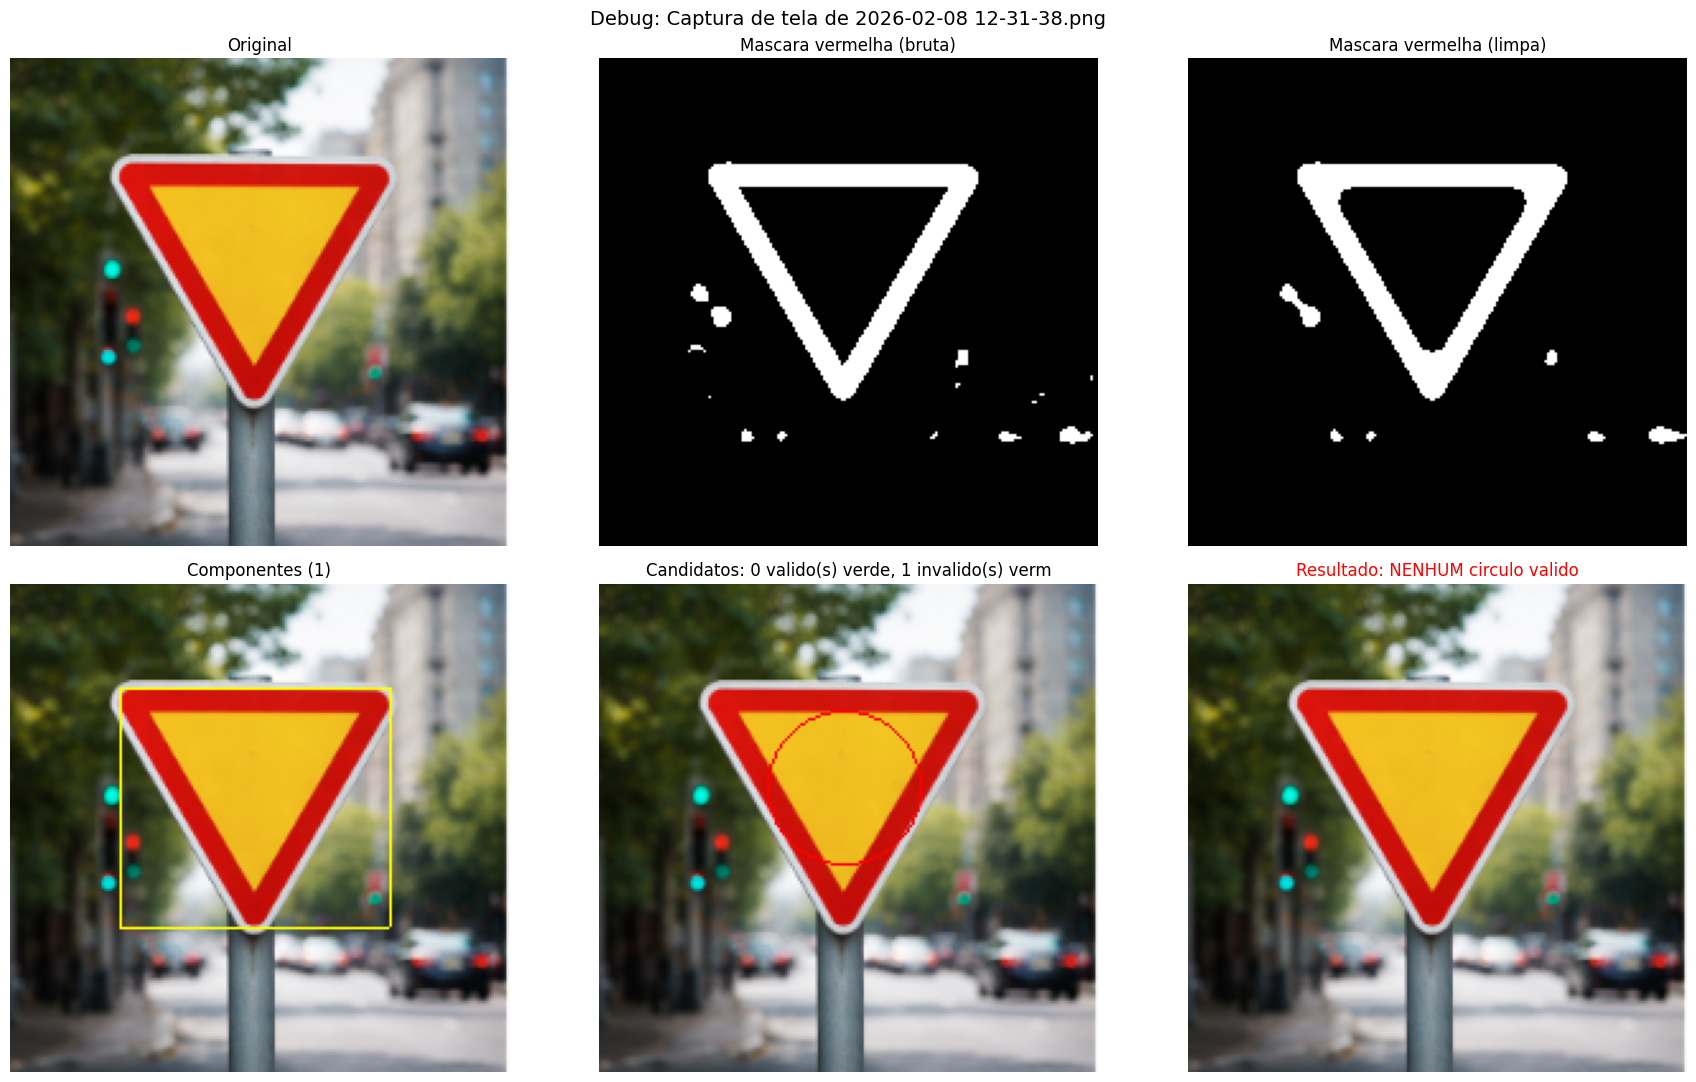


Candidatos para Captura de tela de 2026-02-08 12-31-38.png:
  #  Valido   Score     R    Circ  RingFill  BordCov  AngCov   RadCV  EqRErr    Area
------------------------------------------------------------------------------------
  1     NAO   0.193    30   0.798     0.269    0.750   1.000   0.328   0.467    2681

Tempo de execucao: 115.80 ms


In [ ]:
# Executar o pipeline na primeira imagem como teste rapido
if not caminhos_imagens:
    print("Nenhuma imagem para rodar o pipeline.")
else:
    resultado_exemplo = executar_pipeline_imagem(caminhos_imagens[0])
    exibir_debug_imagem(resultado_exemplo)

    print(f"Tempo de execucao: {resultado_exemplo['execution_ms']:.2f} ms")

### 2.3) Processamento em lote — todas as imagens

A celula abaixo executa o pipeline em **todas as imagens** encontradas no diretorio `data/`. Para cada imagem:

1. Executa o pipeline completo (`executar_pipeline_imagem`).
2. Exibe o **painel de debug** com 6 subplots e a tabela de metricas.
3. Salva uma **figura resumo** (original + mascara + resultado) em `results/debug_images/`.

Ao final, imprime o total de imagens processadas e o caminho onde os debugs foram salvos.

/tmp/ipykernel_127779/872571553.py:54: FutureWarning: `binary_opening` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.opening` instead.
  opened = binary_opening(mask, disk(open_radius))
/tmp/ipykernel_127779/872571553.py:55: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  closed = binary_closing(opened, disk(close_radius))
/tmp/ipykernel_127779/872571553.py:139: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  filled_mask = remove_small_holes(component_mask, area_threshold=component_mask.size)
/tmp/ipyker

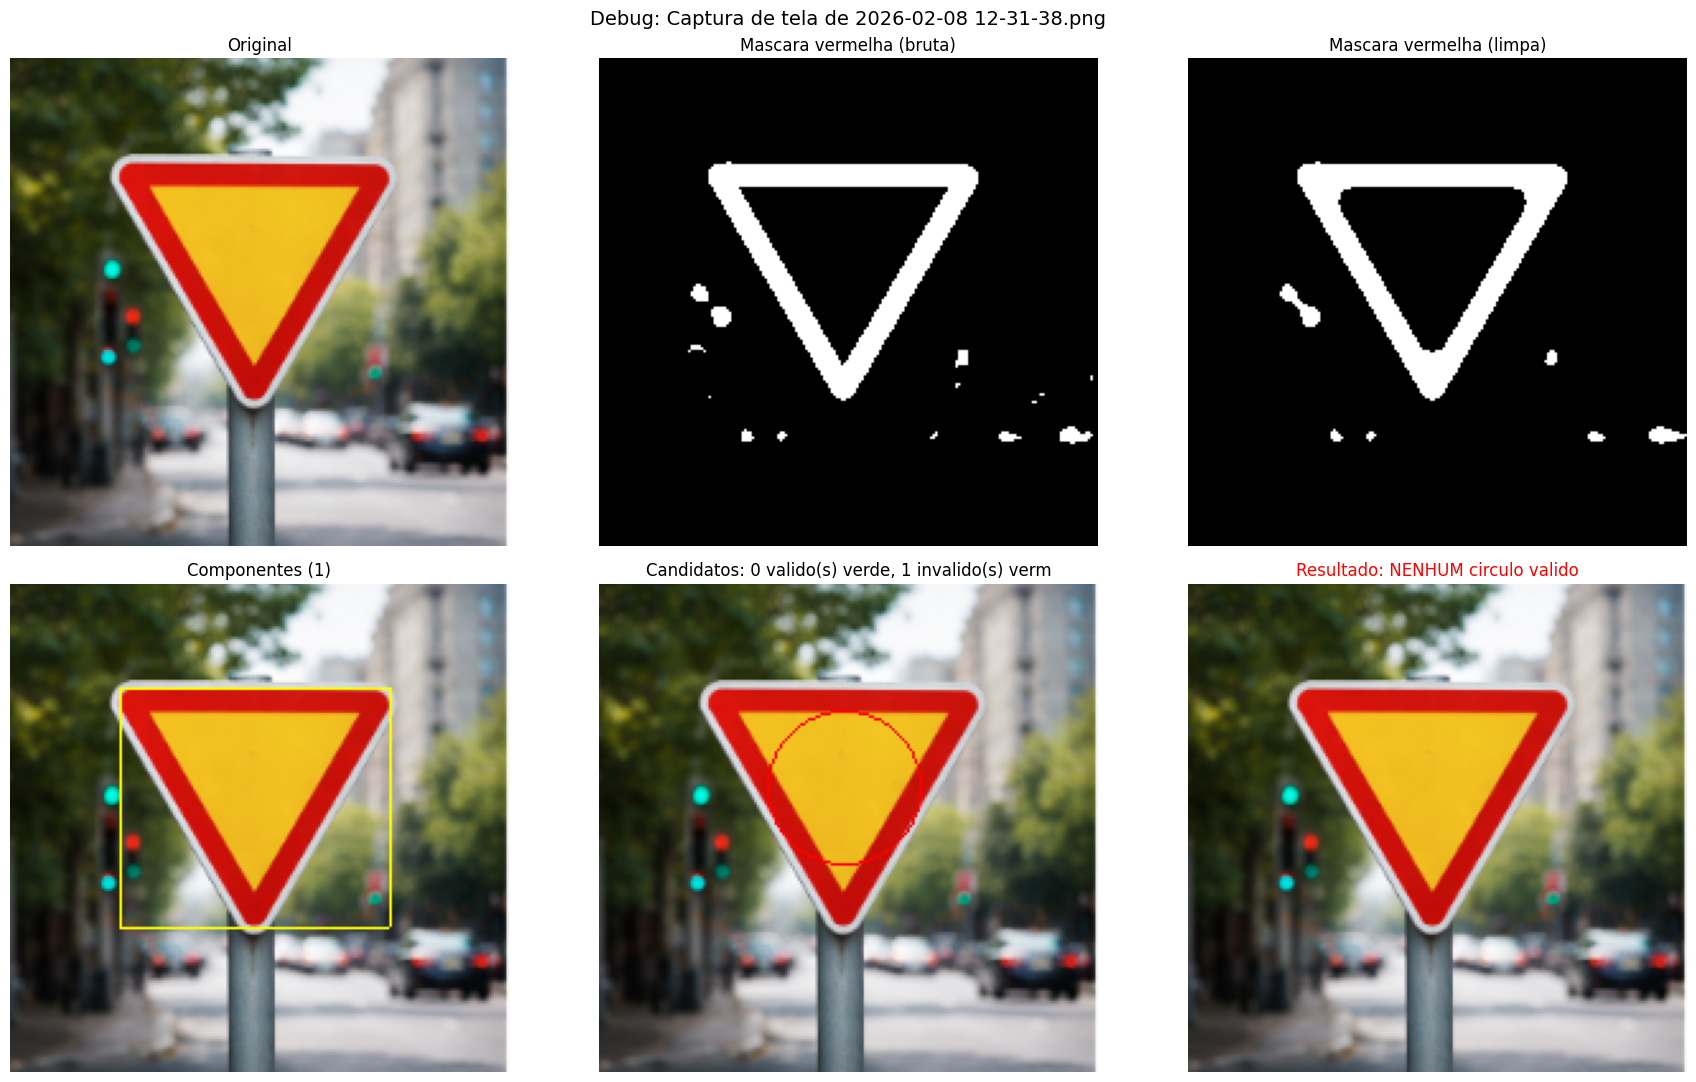


Candidatos para Captura de tela de 2026-02-08 12-31-38.png:
  #  Valido   Score     R    Circ  RingFill  BordCov  AngCov   RadCV  EqRErr    Area
------------------------------------------------------------------------------------
  1     NAO   0.193    30   0.798     0.269    0.750   1.000   0.328   0.467    2681



/tmp/ipykernel_127779/872571553.py:54: FutureWarning: `binary_opening` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.opening` instead.
  opened = binary_opening(mask, disk(open_radius))
/tmp/ipykernel_127779/872571553.py:55: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  closed = binary_closing(opened, disk(close_radius))
/tmp/ipykernel_127779/872571553.py:139: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  filled_mask = remove_small_holes(component_mask, area_threshold=component_mask.size)
/tmp/ipyker

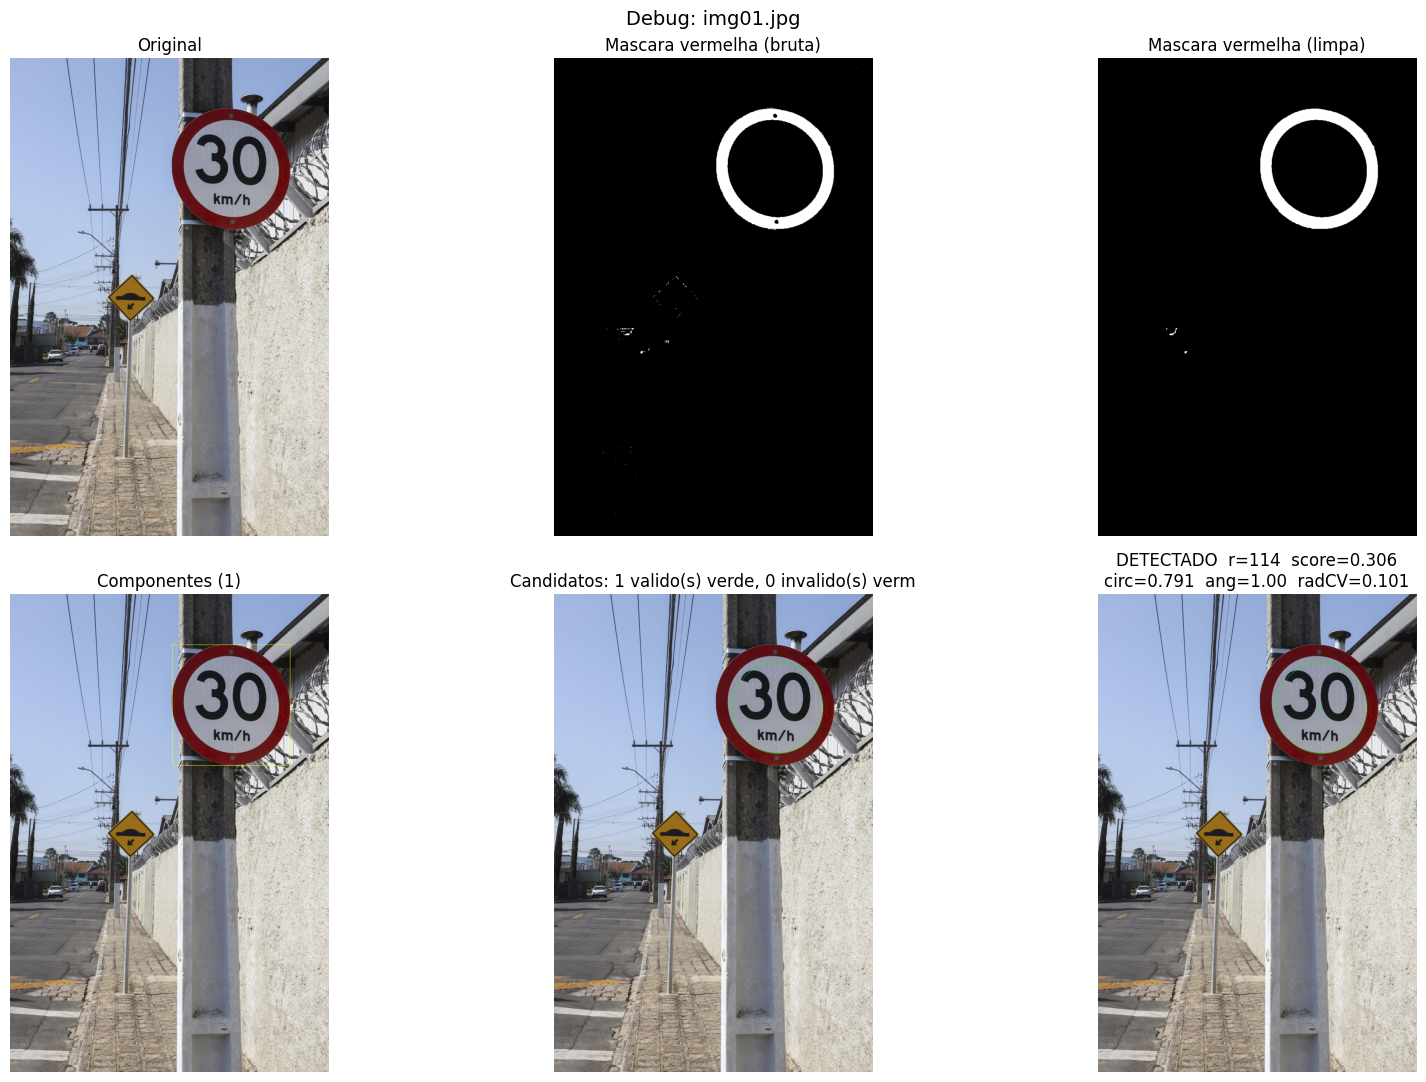


Candidatos para img01.jpg:
  #  Valido   Score     R    Circ  RingFill  BordCov  AngCov   RadCV  EqRErr    Area
------------------------------------------------------------------------------------
  1     SIM   0.306   114   0.791     0.276    0.921   1.000   0.101   0.324   24681



/tmp/ipykernel_127779/872571553.py:54: FutureWarning: `binary_opening` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.opening` instead.
  opened = binary_opening(mask, disk(open_radius))
/tmp/ipykernel_127779/872571553.py:55: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  closed = binary_closing(opened, disk(close_radius))
/tmp/ipykernel_127779/872571553.py:139: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  filled_mask = remove_small_holes(component_mask, area_threshold=component_mask.size)
/tmp/ipyker

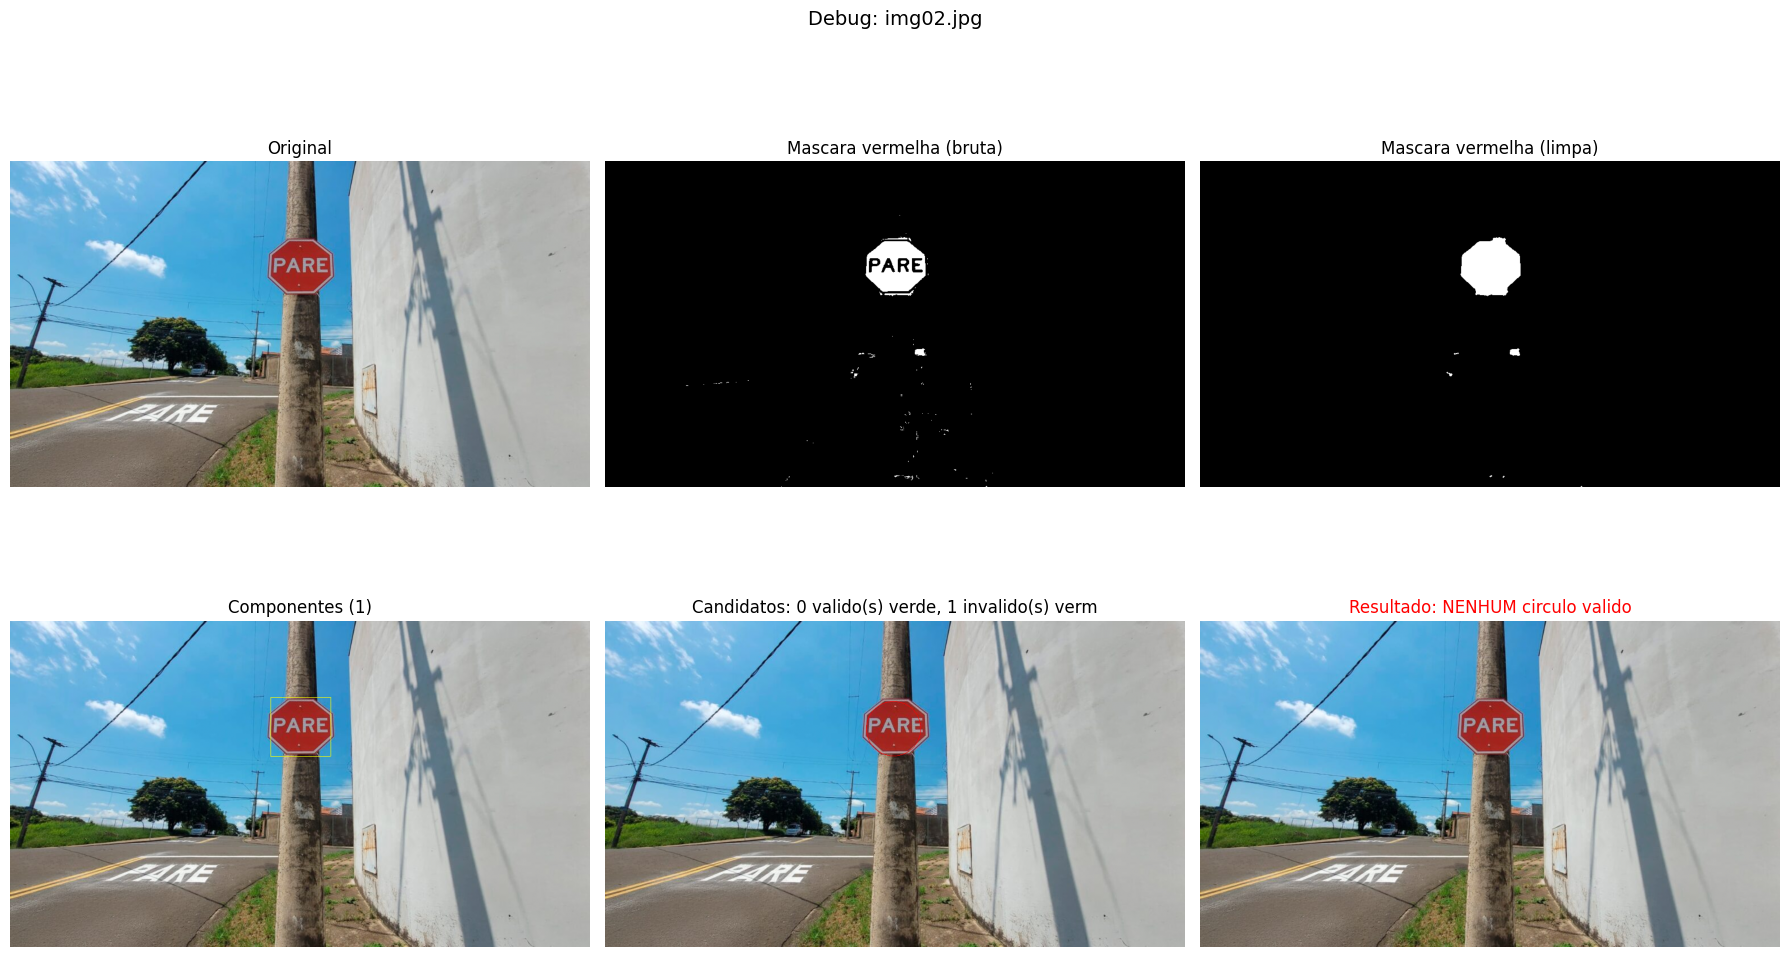


Candidatos para img02.jpg:
  #  Valido   Score     R    Circ  RingFill  BordCov  AngCov   RadCV  EqRErr    Area
------------------------------------------------------------------------------------
  1     NAO   0.207    48   0.801     0.741    0.892   1.000   0.262   0.190    8173



/tmp/ipykernel_127779/872571553.py:54: FutureWarning: `binary_opening` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.opening` instead.
  opened = binary_opening(mask, disk(open_radius))
/tmp/ipykernel_127779/872571553.py:55: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  closed = binary_closing(opened, disk(close_radius))
/tmp/ipykernel_127779/872571553.py:139: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  filled_mask = remove_small_holes(component_mask, area_threshold=component_mask.size)
/tmp/ipyker

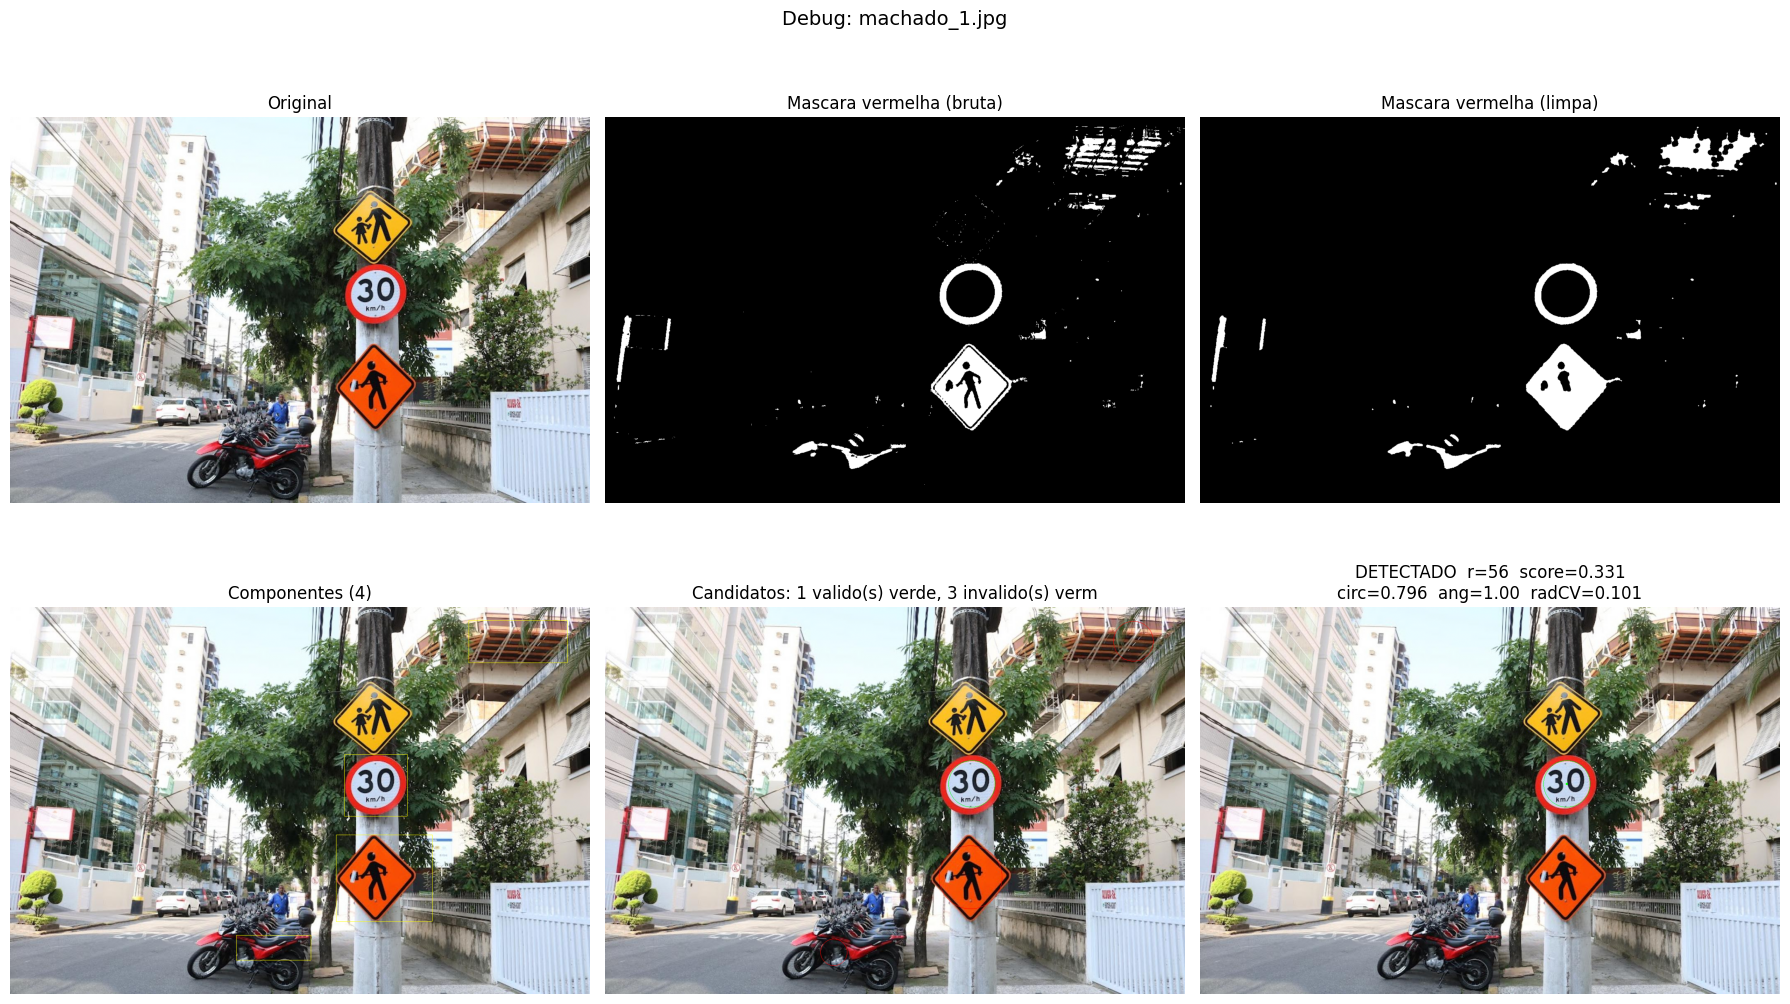


Candidatos para machado_1.jpg:
  #  Valido   Score     R    Circ  RingFill  BordCov  AngCov   RadCV  EqRErr    Area
------------------------------------------------------------------------------------
  1     NAO   0.106    76   0.790     0.442    0.944   1.000   0.273   0.388   21413
  2     NAO   0.143    48   0.668     0.478    0.651   0.812   0.844   0.454   11612
  3     SIM   0.331    56   0.796     0.304    0.987   1.000   0.101   0.340    6876
  4     NAO   0.130    32   0.599     0.252    0.345   0.312   1.231   0.454    2721



/tmp/ipykernel_127779/872571553.py:54: FutureWarning: `binary_opening` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.opening` instead.
  opened = binary_opening(mask, disk(open_radius))
/tmp/ipykernel_127779/872571553.py:55: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  closed = binary_closing(opened, disk(close_radius))
/tmp/ipykernel_127779/872571553.py:139: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  filled_mask = remove_small_holes(component_mask, area_threshold=component_mask.size)
/tmp/ipyker

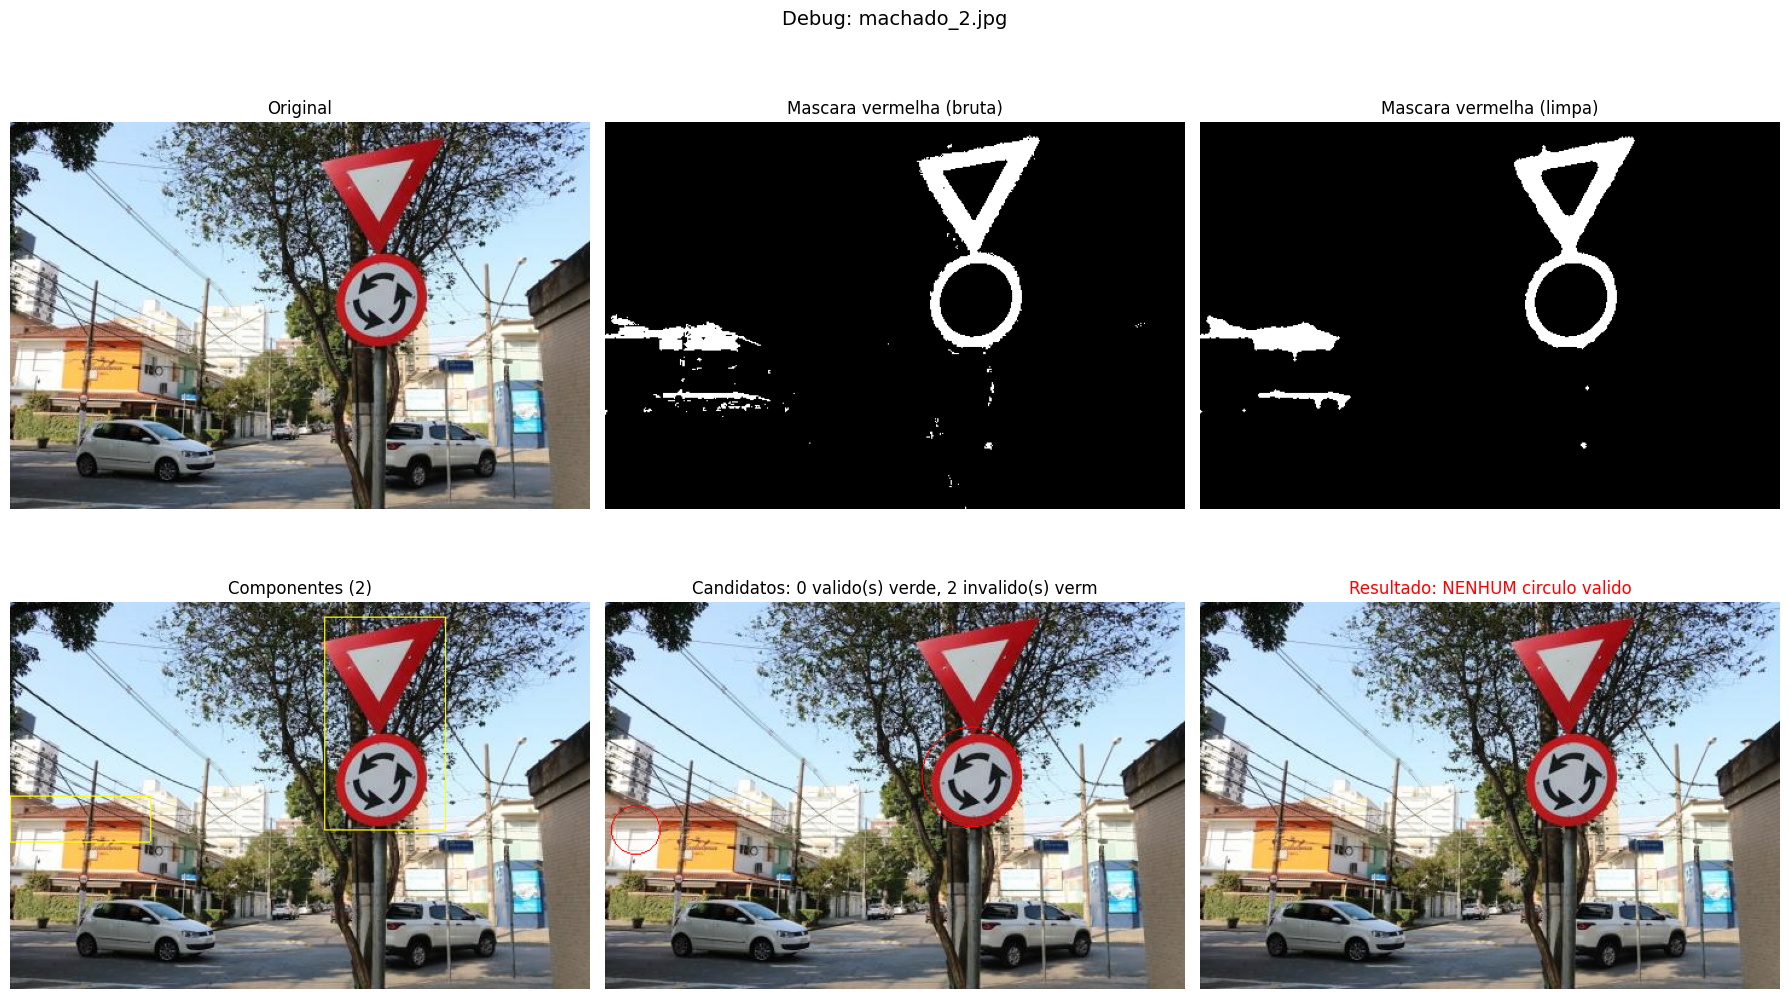


Candidatos para machado_2.jpg:
  #  Valido   Score     R    Circ  RingFill  BordCov  AngCov   RadCV  EqRErr    Area
------------------------------------------------------------------------------------
  1     NAO   0.300    41   0.736     0.313    0.463   1.000   0.868   0.452    5509
  2     NAO   0.167    20   0.599     0.396    0.424   0.500   1.067   0.466    1744


Debug salvo em: /home/givaldo/pi-trabalho-final-placas-circulares/results/debug_images
Total processadas: 5


In [ ]:
# Executar o pipeline em TODAS as imagens e salvar figuras de debug
registros_pipeline = []

if not caminhos_imagens:
    print("Nenhuma imagem encontrada. Coloque imagens em data/ para executar o lote.")
else:
    for indice_imagem, caminho_imagem in enumerate(caminhos_imagens, start=1):
        resultado = executar_pipeline_imagem(caminho_imagem)
        dados_debug = resultado["debug"]
        melhor_circulo = resultado["best_circle"]

        registros_pipeline.append(
            {
                "image_path": resultado["image_path"],
                "n_components": resultado["n_components"],
                "n_circles_raw": resultado["n_circles_raw"],
                "n_circles_detected": resultado["n_circles_detected"],
                "best_circle_score": resultado["best_circle_score"],
                "best_border_coverage": (
                    None if melhor_circulo is None else melhor_circulo["border_coverage"]
                ),
                "best_angular_coverage": (
                    None if melhor_circulo is None else melhor_circulo["angular_coverage"]
                ),
                "execution_ms": resultado["execution_ms"],
                "detected": resultado["detected"],
            }
        )

        # ---------- Debug visual detalhado por imagem ----------
        exibir_debug_imagem(resultado, exibir_tabela=True)

        # ---------- Salvar figura resumo em disco ----------
        figura_salvar, eixos_salvar = plt.subplots(1, 3, figsize=(17, 5))

        eixos_salvar[0].imshow(dados_debug["original"])
        eixos_salvar[0].set_title("Original")
        eixos_salvar[0].axis("off")

        eixos_salvar[1].imshow(dados_debug["mask_clean"], cmap="gray")
        eixos_salvar[1].set_title("Mascara vermelha")
        eixos_salvar[1].axis("off")

        eixos_salvar[2].imshow(dados_debug["debug_overlay"])
        if melhor_circulo is None:
            eixos_salvar[2].set_title("Sem circulo valido")
        else:
            eixos_salvar[2].set_title(
                f"r={melhor_circulo['radius']}  "
                f"score={melhor_circulo['score']:.3f}  "
                f"circ={melhor_circulo['filled_circularity']:.3f}  "
                f"ang={melhor_circulo['angular_coverage']:.2f}"
            )
        eixos_salvar[2].axis("off")

        figura_salvar.suptitle(caminho_imagem.name, fontsize=12)
        caminho_debug_salvar = DEBUG_DIR / f"{indice_imagem:03d}_{caminho_imagem.stem}_debug.png"
        figura_salvar.savefig(caminho_debug_salvar, dpi=140, bbox_inches="tight")
        plt.close(figura_salvar)

    print(f"\nDebug salvo em: {DEBUG_DIR.resolve()}")
    print(f"Total processadas: {len(caminhos_imagens)}")

**Observacoes de parametros e validacao**

A validacao combina **7 criterios geometricos** para aceitar apenas circulos verdadeiros:

| Metrica | O que mede | Rejeita |
|---|---|---|
| `filled_circularity` ≥ 0.75 | 4πA/P² da forma preenchida (circulo≈0.8+) | Triangulos (~0.60) |
| `angular_coverage` ≥ 0.60 | Fracao de setores angulares cobertos uniformemente | Arcos parciais, fragmentos de borda |
| `radial_cv` ≤ 0.30 | Variancia das distancias ao centro / raio | Formas com distancias irregulares ao centro |
| `border_coverage` ≥ 0.55 | Fracao de pixels na faixa do anel | Formas que nao se encaixam no anel |
| `ring_fill_ratio` ≤ 0.72 | Ratio area_borda / area_preenchida | Discos solidos (ex: placa PARE totalmente vermelha) |
| `eq_radius_error` ≤ 0.40 | Erro entre raio equivalente e raio CHT | Tamanho inconsistente |
| `score` ≥ 0.16 | Acumulador da CHT | Fits fracos |

**Legenda do debug visual:**
- **Verde** = candidato VALIDO (passou em todos os 7 criterios)
- **Vermelho** = candidato INVALIDO (falhou em pelo menos 1 criterio)



## Conclusao

- O metodo funciona melhor em placas com borda vermelha bem definida e pouco ruido.
- Falha mais quando ha baixa iluminacao, blur ou objetos vermelhos nao circulares.
- Ajustes principais: thresholds HSV e faixa de raios da CHT.

Entregas geradas por este notebook:
- `results/debug_images/`